In [1]:
import warnings
import polars as pl
import polars.selectors as cs
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
data = pl.read_csv("MMM_test_data.csv")

In [3]:
data.head()

shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ start_of_ ┆ revenue   ┆ spend_cha ┆ spend_cha ┆ … ┆ spend_cha ┆ spend_cha ┆ spend_cha ┆ spend_ch │
│ week      ┆ ---       ┆ nnel_1    ┆ nnel_2    ┆   ┆ nnel_4    ┆ nnel_5    ┆ nnel_6    ┆ annel_7  │
│ ---       ┆ f64       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 30-08-20  ┆ 157906.75 ┆ 2625.48   ┆ 262.71    ┆ … ┆ 3609.63   ┆ 12955.29  ┆ 12659.12  ┆ 19379.79 │
│ 06-09-20  ┆ 186425.68 ┆ 2634.01   ┆ 108.66    ┆ … ┆ 4560.6    ┆ 12747.7   ┆ 12338.18  ┆ 22473.45 │
│ 13-09-20  ┆ 161607.39 ┆ 2087.08   ┆ 110.32    ┆ … ┆ 4362.96   ┆ 15015.41  ┆ 10811.15  ┆ 22596.05 │
│ 20-09-20  ┆ 180089.13 ┆ 1690.7    ┆ 52.79     ┆ … ┆ 3883.41   ┆ 15521.41  ┆ 12890.22  ┆ 24728.73 │
│ 27-09-20  ┆ 217793.98 ┆ 1547.3    ┆ 80.56     ┆ … ┆ 4043.09   ┆ 15793.74  ┆ 12642.55  ┆ 26515.48 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [4]:
data = data.with_columns(pl.col('start_of_week').str.to_date('%d-%m-%y'))

In [5]:
len(data)

104

In [6]:
def autocorrelation(series, lag):
    y = series - series.mean()
    return (y[:-lag] * y[lag:]).sum() / ((y**2).sum())

In [7]:
# Extract values from polars
y_values = data.get_column("revenue").to_numpy()

# Calculate autocorrelation for multiple lags
max_lag = 53
acf_values = [autocorrelation(y_values, lag) for lag in range(1, max_lag+1)]

In [8]:
import plotly.express as px

In [9]:
list(range(1,4))

[1, 2, 3]

In [10]:
px.bar(x=list(range(1,max_lag+1)), y=acf_values)

In [11]:
px.line(data, x="start_of_week", y="revenue", title="Revenue by week")

- we can see clear negative trend, which might be indicative to the economic downfall
- there could be some seasonality as well

we will use Prophet to know the trend and seasonality of this time-series

In [12]:
from prophet import Prophet
data_prophet = data.select(["start_of_week", "revenue"]).rename({"start_of_week": "ds", "revenue": "y"}).to_pandas()
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, seasonality_mode="multiplicative")
model.add_seasonality(
    name="monthly_seasonality",
    period=5,
    fourier_order=5,
    mode="multiplicative"
)
model.fit(data_prophet)

/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

08:07:37 - cmdstanpy - INFO - Chain [1] start processing
08:07:37 - cmdstanpy - INFO - Chain [1] done processing


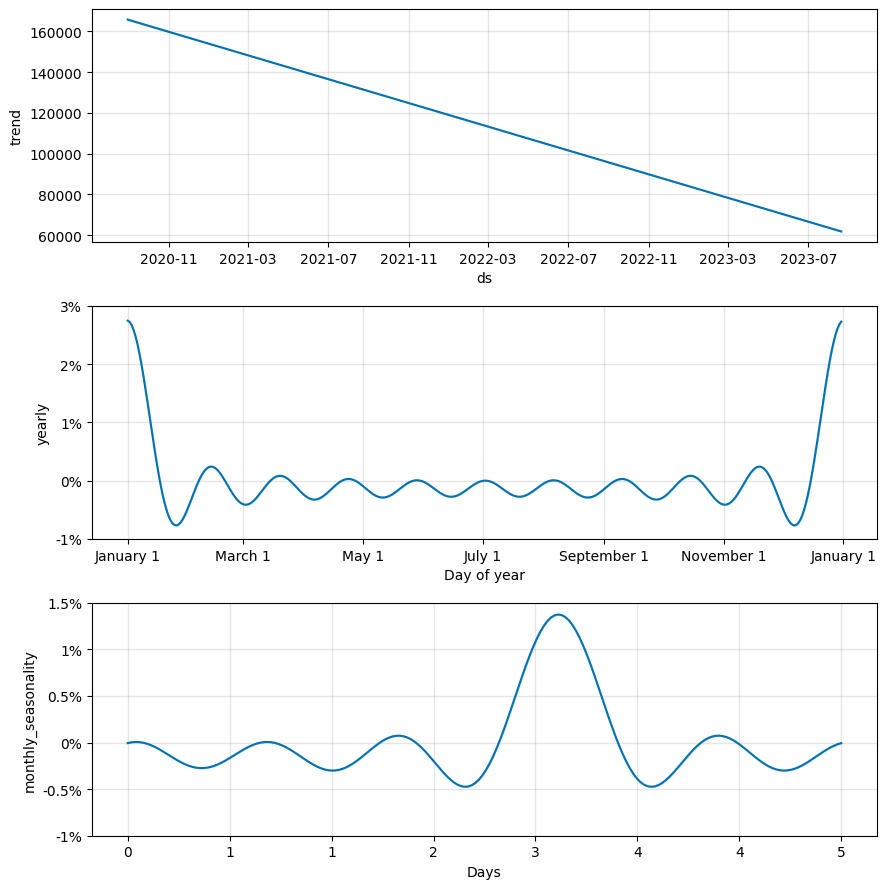

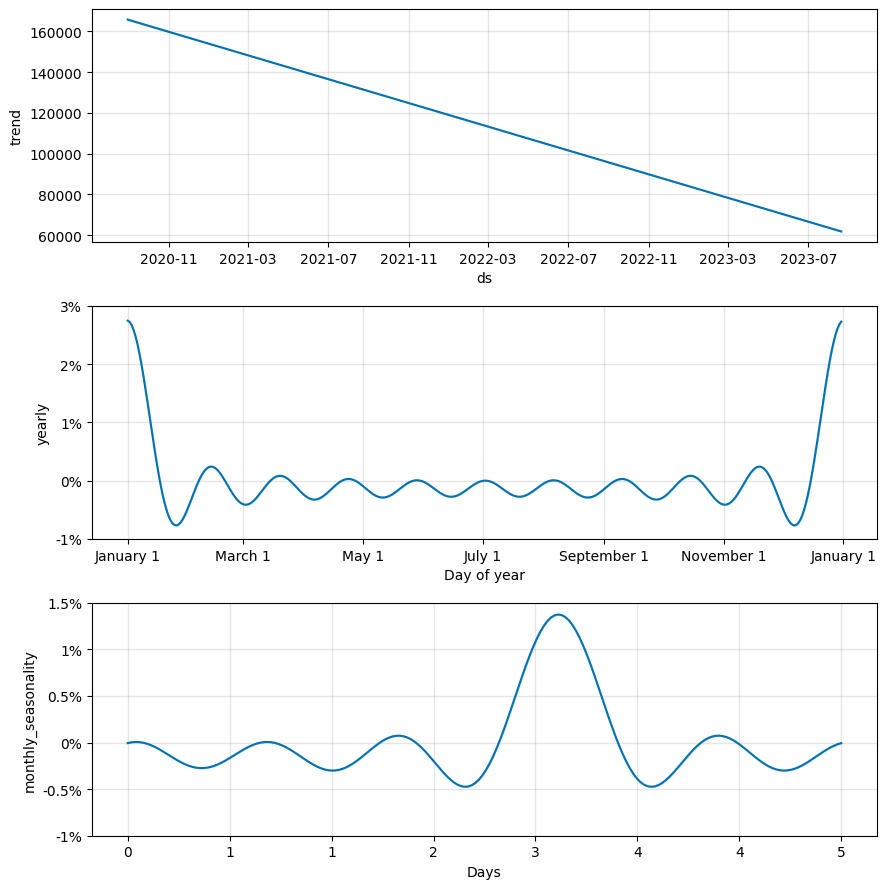

In [13]:
future = model.make_future_dataframe(periods=52, freq='W')
forecast = model.predict(future)

model.plot_components(forecast)


In [14]:
px.line(data, x='start_of_week', y=[f"spend_channel_{i}" for i in range(1, 6)], title="Spend by Channel Over Time")

### check for trend and seasonality in revenue

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
result = seasonal_decompose(x=data.get_column("revenue").to_numpy(), model="multiplicative", period=52)

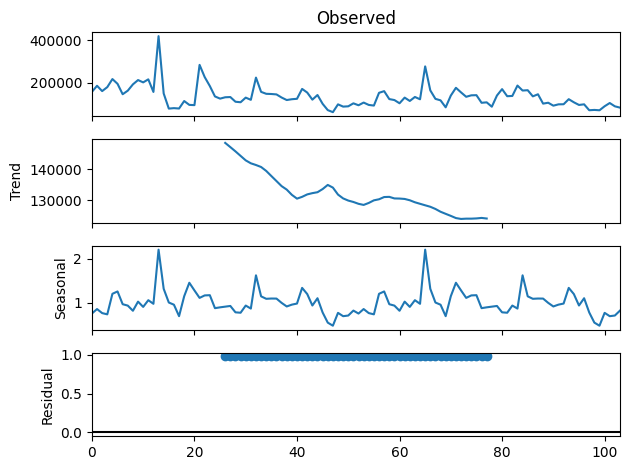

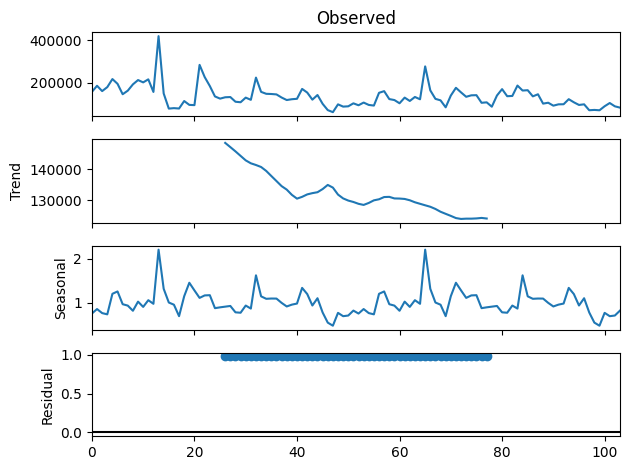

In [17]:
result.plot()

In [18]:
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.prior import Prior

In [19]:
total_spend_per_channel = data.select(cs.starts_with("spend_")).sum()
total_spend_per_channel = total_spend_per_channel / total_spend_per_channel.sum_horizontal()

In [20]:
prior_sigmas = [i*7 for i in total_spend_per_channel.rows()[0]]

In [21]:
X = data.select(cs.exclude("revenue")).to_pandas()
y = data.get_column("revenue").to_pandas()

In [26]:
type(y)

pandas.core.series.Series

In [23]:
my_model_config = {
    "intercept": Prior("Normal", mu=0.5, sigma=0.2),
    "saturation_beta": Prior("HalfNormal", sigma=prior_sigmas),
    "gamma_control": Prior("Normal", mu=0, sigma=0.05),
    "gamma_fourier": Prior("Laplace", mu=0, b=0.2),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=6)),
}

In [27]:
mmm = MMM(
    #model_config=my_model_config,
    #sampler_config={"progressbar": True},
    date_column="start_of_week",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=[f'spend_channel_{i}' for i in range(1,8)],
    #control_columns=["event_1", "event_2", "t"],
    yearly_seasonality=2,
)

In [31]:
mmm.fit(X=X, y=y)
# mmm.fit(X=X, y=y, chains=4, target_accept=0.85, nuts_sampler="numpyro", random_seed=42)

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1s89h_t6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8s2ndi0r

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j6640_si


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2wraluxu

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jmo7hbfr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yurj6601


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ly2i2rst

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lq80izgs

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_r1uau6kk


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([0. 1. 2. ... 5. 6. 7.])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1b5ocvy1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_chz_ro6g

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0nk8dcnv


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(7)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hkssi32s

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4tbl4gac

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j55zxkll


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_49zt3he9

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hl4p26w3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jzc9dw85


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3xxnzewa

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xijan2st

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fe90ku_8


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Ge(0, 1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nw9rihb0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fny93zz9

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2xx3wd4j


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_k30__s9_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_o_7odwn8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dhekp6nn


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9_l0gpt6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1l840qjm

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yjjh0ssw


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_v0l1ago8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hkxdh2_m

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_eho0o1zf


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0.017202423838958484)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/pyth


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jukbq4pl

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fa6z8x34

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_eu50qxje


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__f5fhyus

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1ewsywks

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_d5o_csgc


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3vyhgkfh

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ty69jabc

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__mow0sy9


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2fl6wewf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j0uf6trk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sm708lf9


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Le(1, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_z_vqyl5d

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_d128zr67

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xjtcy6oy


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Eq(1, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_z3imigyj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ghzkpj1g

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_i2_6or50


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fxx9dmqv

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_035m9it2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_eph47mnm


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sy34mdal

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_82c9vhb5

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_iegrzy5b


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hx0zoc4h

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gvk944vy

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ex2kv07k


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cqod7pcz

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__47wkze1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ct_yh6tb


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(6)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9i11zkik

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5v0tjt2d

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_v4ef2fn4


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bfnr9dii

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dptn8zlr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qmhcul7l


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ddc0w3vo

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cs3fop2a

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yi1uzfye


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_m5e6q3vb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_u1v8qv00

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j3765nls


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_du49wphi

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rzg2ofs8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_w0wfu1tl


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jb6pnydg

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_viuvrz1_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nfvf1_au


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bs7iwi20

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yldzjb2n

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_y2lsx6l8


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([0. 1. 2. ... 5. 6. 7.])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_e0u3j4vf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_l0syzxrd

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3tzihyxa


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(7)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1oaidjm_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gc0tz9br

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ywl44zjw


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8a0jqu52

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_utkjdvcl

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_u__y614w


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1kf2p3ms

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wh4ppokm

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_y2fkoo39


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Ge(0, 1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_76n73gwq

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ef6ilzdy

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7klnz9ut


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hwmewyar

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8cddtxbp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_x9p04m33


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_89mm43a_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zj6u5c67

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_249fbs8l


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rjl9ra1p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_amq9vq0k

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wqj6eu77


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0.017202423838958484)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/pyth


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_opja5jqj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_o9cszsvx

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_16f9wmp6


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_18o7_4w4

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3dlky1z5

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bc0l2pxp


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lslzrn9p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7lk26u42

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_m_4mcc92


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_y941ae0f

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ebouw7vs

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8j7e8qvi


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Le(1, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wly87mtl

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0y3x93az

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f0j5gylz


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Eq(1, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8e67sepq

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_q8rq6yv0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_95l4_jg3


Initializing NUTS using jitter+adapt_diag...
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesi


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_e5k9nf0u

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_g_3jgvy2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lrfmymwo


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_o3hk0_hs

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fy7za_z6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_msvwsml_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zx2goywa

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3jtoy4po

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3c3dm0h9


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([0. 1. 2. ... 5. 6. 7.])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j792s_5l

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_74lqc_ud

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hrizsgl_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(7)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_m9uvg2r5

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8suzeqij

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ly5f8dqm


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j4fk0fzs

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j2921f65

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ihlfixga


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mvtu34kc

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gh0nlab2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_w_xy709t


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Ge(0, 1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gkt7drtt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2_vh4ztk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__rsgclii


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8x0an1cl

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xz5j4dkj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_62jrdukm


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_u0ur8jpm

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9zflqt7x

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0_ibsl2w


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_exhj5w5s

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_k7ciqxo2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wr9np5fy


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0.017202423838958484)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/pyth


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1g7ph1bf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_o0y9ltr1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_m83kl927


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nyp4qnjv

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_84id1gre

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nguswimj


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qnajfm5v

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_r42pjpx9

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_14kx07ga


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dkznf33r

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_s388i0uz

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4g2j0ymf


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Le(1, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wely2im3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ou635ugy

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_m6kwm6z4


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Eq(1, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_l63hqmcs

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_39yhto2p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_efq3ofj5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_a_0anpf3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gai8fin3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7yb30bs8


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_39efx7y7

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__wu5gyh6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_x024f5vg


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_q4ycj_d9

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_m0na_1dr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fv35g9r6


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7lm750bm

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yb36yllb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1_5ngxid


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(6)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qy_vwe80

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wooy927y

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zi497spd


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sjba4bj2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3x61l48c

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9xodu9i5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jgwmla75

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fenyldrh

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_os0f66lj


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_x30wstyr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_t7edb7ci

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_887zzzop


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wvl1xlhh

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_uy27nccx

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j3shjy0h


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1b_cffjp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_my93q65i

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ob5lvp97


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2v33xk65

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_oj1vinet

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xgpke03b


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([0. 1. 2. ... 5. 6. 7.])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_swsynbai

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rd_k5cnj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0vsefbra


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(7)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5ov0bug3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_iq11a66b

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vu69r93j


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_55amo_ds

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zcoltcfb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ck1kelpd


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qkw7srx9

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9m67wya1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2q0vj8zr


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Ge(0, 1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7olsef4r

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_znzr6s2p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nic1cxlo


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_09n__8_x

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8jjw9oj5

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_n5661wt8


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_urde8kto

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mc3fh78w

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_oqkhjv8q


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jzxbpjqi

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6k2jp_g7

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_met4vs9n


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0.017202423838958484)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/pyth


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1f5bom_8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jmz5wnq7

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tb5qc14u


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9hq7wi_7

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vx3yv8dt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4kc5gcrb


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_11iddvwx

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9z4zfpcb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_i32ns96t


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_t6c6qftk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_puorkv61

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_n_9604qa


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Le(1, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ri8g77vt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_00okfci9

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zib3uhk9


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Eq(1, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qt7v0x9q

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_oagojgz4

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j8j1ta7q


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8pxw48a6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nj_s3iyw

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7s1r3cuw


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__lq8l77q

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_uz7a9an9

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_c78do0f5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float32}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9sypmgjt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5_u7u6z8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sykqd_6i


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j_jizlrj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mye0zhjf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_51c6lzt8


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fjzijmpw

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7cq0a_9z

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rer0kbe4


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.25)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_12g84flp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1rctgco4

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hjaq1q61


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_z2uq4r9_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bfw9uug1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qq211b7n


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1etgtsts

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_uiwx7353

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_h090s8ou


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_o_p6pb2s

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_73dbv9vm

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_np9_kph2


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_58xc6wap

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_o9mnnewy

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_56odcc0g


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_i0485oby

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1e10tp79

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yv6igo5k


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_z_mwwt67

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6z49el3q

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ugq4k9hx


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(6)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j8_iz11p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_seaxf2cb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dnbs1leh


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7jhuctgp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4niu38r6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rxpt4h8t


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_timn31mt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rhpf9nvd

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5i5_b9_0


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1u83e4y_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vtstbavo

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0fnsxgkb


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vzvqzr16

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2ndkn30r

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sb6_nydf


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float32}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cme_52nf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_pgia8lfk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_s0j6xra5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(-0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyten


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vuotn9r6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0v68w0pg

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hpil4cwf


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(-inf)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ykwog3zw

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cudls__m

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_c9q75w9h


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_x62cozqn

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_l_lu4b6u

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0m5ab0ws


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hh9ucoek

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7pb3zpq1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bzbuwo1v


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wrkvoq_g

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wdy4tleu

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_oalv5ex6


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sb_ig0cs

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2ubrzh8x

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__tpfvyno


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__boa3zh3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_aprtotp_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_t1ostc3i


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f837y78p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ceug8mb_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_n71qd203


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(6)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_n_jqhwvd

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mnyg3fe3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dkrknmco


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_e5ajwsir

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1ht75p6b

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jixxerbj


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jdfr0gzg

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3a8bhz31

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6_j_hqb4


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_v7zcc20z

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__iie7z7a

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_og0n80k_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jxanzyrf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5ifznikf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yjiniclx


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float32}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_68j_8v7g

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hawi4ab5

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ypjme9ya


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(-0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyten


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_213_d8ha

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_k0__gzwk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jrkd6ow7


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(-inf)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_39z9pk_3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__mgvrk2c

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nsjeemb2


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(1.0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_y58sgj2s

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8zrhc8l7

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_v5y6cb6k


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rz7xwjoc

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0jcdvbew

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0jdykshw


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_31jt825b

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6eorruoc

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cawdb5kr


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vd0ip53u

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_80z3k9tq

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_spi5y989


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qmbf8k8m

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__l3qkhsi

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wtzy_azl


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([0. 1. 2. ... 5. 6. 7.])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ikvji7ez

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ottq9_ah

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xnaf_77w


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(7)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_88llwxwr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tvxq9bvz

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ttj3divz


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bgulenzt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rswyiyg6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yk4rxyyd


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_b2yu0rp5

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_oxmjc4cj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__c8bbem_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Ge(0, 1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_q71l__ly

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2sg5r7e2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ilzf9cjw


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_30qmv0k2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nqhztvks

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ccp5mmeg


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(2, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fywz6vrw

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sk7t474h

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_87s1gxqe


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_q3ujgt_6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jru93cvt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4nreou2l


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_79il2zgg

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_o8z6_14w

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kvlgsctz


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7w1t8rf6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_q18r6cei

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_s_vm438l


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7raii1vs

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j7487q3s

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_15u95u6u


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0_hzekl5

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f4m_v__1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_84wm52fq


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_t4nkimlr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mtb502jg

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_r6afumxw


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Sqrt(6.283185307179586)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5iuz2vcb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mihjexhq

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kdgj2zm6


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0.017202423838958484)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/pyth


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tm2j0h3h

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3qsxu31u

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ompgdk8l


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1iltj83m

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kyi3khrc

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9eq8x3pf


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_k5tc89b4

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4c9_o14d

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_umrefngw


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3yrozjyk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_p3syia45

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_33d2h3ty


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Le(1, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0ui4u61l

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f92n9dzo

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_na0lpbu3


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Eq(1, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3x627za_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ub31ic0p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_11vt3h5b


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(-0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jk67rt_v

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5lnbfa5_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vrfsp2np


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Sqrt(0.6366197723675814)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hi9q9ozg

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0fay9k76

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_e4zxuv0z


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(1, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ae7s2ctx

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_g7nwali1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_e8vpw3yt


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f52ahtb_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kfsnqz6t

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7k0a4wyx


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(3, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cal1fbur

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_h9hg0j5u

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_a_aya8n3


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8vvajwbz

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_b0ry1jr8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_eqg41in4


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_43zkloiz

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_e2ertfrw

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_c5nfkmub


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_u41h_g2w

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ljc28xr9

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6hpgvn9o


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4_b_kvnp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_w0ptzd2l

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jvtt1rkv


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8zij12r2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cssm4vau

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ygrv562t


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(6)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tfta9bpa

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6h7cxt3n

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_i3s2un78


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3hj6k994

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ry4e2l81

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f97skwct


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mk0i9lqc

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4ery7c9h

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bjejwyfm


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1r6pn0d7

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4wnqw2eh

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_45q6d15_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cn8wbs_7

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_94ss6eui

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rp67_lkg


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float32}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_d08gnz8h

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_njj33xtc

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_npcaca0g


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(-0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyten


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_n2mxfzye

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0k236710

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nobe54ty


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(-inf)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7ga5cfw9

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_t3ytol19

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gy12ym55


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(1.0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_u697l3xz

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rojw4mho

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__spdfobk


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_p6yemfhl

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gegwjns0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vm0i_w45


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_638c2yrg

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__95_48_8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nwsy6qr6


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lar9f5w6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_utt_6vff


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(-inf)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hpgslxuv

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_k40w5_t9

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_m0plw7ll


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9xwrr2ti

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ktagty4j

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5f3jcl7g


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_khlggpuk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_frwx2r9x

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mmx7kf8m


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(6)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kbdh1yao

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_14gv4lb4

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wwcazp1u


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rvaa_jli

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_e82xjbe2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7zsbvhil


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_04o4r7p6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__tyrx1rw

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ufr1cea5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_aa9fgrna

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lsawt5u4

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_87i3op9x


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f0ztsnqb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_u0zn42qx

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_s8ymirnu


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float32}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sthqzlgo

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_m_yodk7q

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_p2cx4eh2


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(-0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyten


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ub516hoq

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hw0dtfw3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ibhs2sfw


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_muwiak4n

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_s9lof28c

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ph1st6vi


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3zcpw_x6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_safs0y_7

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4197vouy


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(3, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wlc7ze4l

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_i4f72ow0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4ti5fov4


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dtytah0y

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ajuspy5h

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9z_khrw5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2nxna0qa

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4qatt0ey

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tirbqzqs


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Sqrt(6.283185307179586)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bx_errxe

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f8zv0b6p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_q__2b8zl


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0.017202423838958484)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/pyth


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hdoh3zai

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_prhwh654

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8736b1np


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9pk637jr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dh1xyhb4

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fhxjb52m


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(6)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cjry1ij_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cm5vh7cm

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_n9gkz7dn


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9jqbl29_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2elljrwt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rkfrv97o


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6t80lc_d

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_63pfg7wx

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bveak5z5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_o3_rhx8e

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jvs630ye

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j3qmk2tr


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rxx_0_bq

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cvkjozte

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fyc56euc


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float32}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_euwmc6bp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lo61mtg8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3kl9dn7q


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(-0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyten


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vxkji92b

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qc_fnm86

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lp7hcaq_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1sxnlnxl

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_m5dogfth

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5cer9wr5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fj3mz8l6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5j50m9fh

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_d086zkqf


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(3, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ak6vuwp5

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5ui2etzx

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3ve72vmb


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wrpg2pts

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_67tjclrr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__cm3fkvf


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kt4q9q2e

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_em68b65_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_06pko2ci


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Sqrt(6.283185307179586)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_t4tmqeez

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__h1bzvw1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_b7e9txh2


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0.017202423838958484)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/pyth


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ky3regt5

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qm9weu6j

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xrzmacmg


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f5fbakqq

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_56q_je2l

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rlfdbn1x


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(6)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_l_4cpn0y

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mkcqio0e

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tmi8jfc_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xuq2ntt3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_98unu468

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_z_ry4oac


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_l6xkp1fy

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dv1c5k23

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_669fye2y


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gkng90gl

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ard_qx75

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kycl_nc5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_veadmdvj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_y3dymul1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0pi84ife


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float32}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_819toatn

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sv873341

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__p3t3ope


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(-0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyten


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_uwhkvumh

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wuiljgk2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nh4_s7cp


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wqd4_ydj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rj8694sv

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dy_u4x7f


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_frsr66ei

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_a8khtef6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_a882dgsn


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(3, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_g68gjlme

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_58pg52dr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_i2j6niuv


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__grqvly1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_swsbfvqs

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qg1avtkx


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_22s4zvj9

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6j7xzjd3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_peznc9vl


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Sqrt(6.283185307179586)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ygwldvi5

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7ms6et3b

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zyai4e9h


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0.017202423838958484)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/pyth


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_24cgf0sd

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bu0r11ha

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_u15jta1w


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_aev2w3uo

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4vrwpaur

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zfxt0ijg


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(6)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_07zu66e3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mi9kn25q

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_e1mgrgnh


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vxujfdbl

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9gf3b03p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_u344fm10


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ijqfgtmh

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vgec8a8f

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ui0qjwuz


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_g0nze56u

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_btjn7sm7

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xyhlgysj


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nxqjmswl

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_15qq3hwd

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cl502f2e


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float32}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_d9bmc4pa

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rinxyp0x

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xhfyd82x


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(-0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyten


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ez1lxd1c

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_x3nhw63k

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vhgpprxf


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_h_0616dz

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_q6zt8rbr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2ivwvn0p


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_s2jh0yjm

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_axnn1kex

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gn8zran0


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(3, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mu7vkq0k

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dfg0o5pj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hlwfbejr


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6hbtcg1q

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_te9m893p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_eb49be1s


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_z8_rkqtd

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_owex02v4

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_o8gfqhqs


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Sqrt(6.283185307179586)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_noopejzz

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_p_a4rt6_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jg6avmt3


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0.017202423838958484)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/pyth


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qgxoh_q1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4nn7qqcj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qjuxwvt1


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1odyocca

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ehd_ywco

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tojli4qb


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(6)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4os5j_tf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qaoxqb1p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rs9figq9


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1dq1rp8h

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cifryu_x

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7ssl_7ak


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__q5y50pt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mk0ih28b

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_x9wdfxlo


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f40b97yb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yvvr71yb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ikvdhkjf


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qy0_5sma

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_l_pxw48y

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_axc3kqp1


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float32}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ur_3_w9w

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lxpsaxos

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5hcmw9kt


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(-0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyten


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5_ky36ex

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wxz42cd5

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_h4qks5ao


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dsfhcnlh

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dgjnm9iv

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kjmvifx8


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qrdmt94r

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j7v6ypsm

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_l8cv4ze_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(3, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4bhn_kce

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mgimm6x6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7f2v33qi


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lidqwr_v

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mjxmcwt0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_my9t1tfk


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(-7, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yhr4dyaw

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_slpdvb5g

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_c98p90_a


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_usapzmro

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_horb4otn

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_t7ws4au7


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Sqrt(6.283185307179586)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_24mpv5g_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8d8v5gsq

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_djj_ihux


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0.017202423838958484)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/pyth


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xj6tbfrf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jrbp80m6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gbh0fj4j


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ocdig9vj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9zsizbhg

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_s_pp2hkf


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(6)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5bfdmlux

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lp4flxj0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3rqm0kq6


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2je93bl0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1rkjv5yr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_oafflm91


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ztsi8i_3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zjc3rl9s

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9cxg69o7


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mypgjn19

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6svjc4qv

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ha62zqsk


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bd4dr2le

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_p98hd2pk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_asi7w75i


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float32}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hb7jq1zq

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_b12_tc66

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_grgo2ppg


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(-0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyten


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jxpi3y3m

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_w8ullfiw

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_t1mr6i1s


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sl0brfio

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3cgdemmy

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_z3ri6wh2


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_oypzkngp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bbc_ojrk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_35k9zf99


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(3, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_av1ar_e9

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2ljf9efb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_roqzrxd8


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_a_9ba9dw

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mh42rpix

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5jniash9


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(-7, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_q6_ekemx

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_uypijcgt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lnp2iicj


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_47wwosxr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_t1q2yy9q

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_66jpm3q7


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Sqrt(6.283185307179586)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hxs88e32

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_56_vy0bi

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bppfd1kp


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0.017202423838958484)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/pyth


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_otm8exej

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_o5jnpql0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sjfcpare


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qdsf0gkg

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_h5abqg0c

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fta8uksg


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(6)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ymyd78gp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_i4x0nlkr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_iql3d10m


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2hkozp5y

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_v0jrsv9f

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_v17p25l4


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_33wq4co0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_a976r_qb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_u52wcxkh


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__p8v0cfd

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_oi28zs3a

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_k25xv9v_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_so2fcso7

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dinh9xrx

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hbyyvwta


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float32}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_v34ycuj8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xbhmt03_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ac_nqfo1


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(-0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyten


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_o1zbtshw

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rjhio1xs

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_l9w06xut


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5cjpj32x

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_a5krpuqj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_pg_utpb3


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_na90w_ai

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_670x0ovp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qchp3d2m


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(3, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mzk_73hy

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_r5vgurq6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ke3ls_1p


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lt9o8r8e

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wwiod4jj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_p3111r8_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(-7, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jyrd70dh

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kyssv57j

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rkp910uh


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cfjrqi0r

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_d9o3f510


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(-inf)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_69q363ku

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9mo5vjsz

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gx9_nvnq


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([1 2])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ayf5mst_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_uvckx3jq

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jgognk6e


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-inf)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_y9fv35zl

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nadfda__

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_o3d608o4


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(7)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jm2favgu

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_d4bor8re

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ji9gigzl


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_11g0lye2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rz8xiebp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9_ateedf


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xghb8mkg

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2e4msxwj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gmkbz7w2


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jsvji0dd

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6b2_bl8k

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9pt6q23x


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packa


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_n7hfrbdp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0o86gtwr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_u90bnn7s


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float32}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_eazskv25

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_01hjf1us

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dkrkxcxt


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(-0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyten


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f9m9u5wk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2e2drx18

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_p2_8jeaq


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fpgge3kf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7xr6rz_z

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ewjgtix2


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(3.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f6oy9_49

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_w9tgsejb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jv4z1b3m


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(3, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qqt_a4s3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_juuanck3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hktep06g


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ljfxtnhw

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_og_5d9qu

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lw17gbx7


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Add(1, 2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9216ryr1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_addpqi34

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_m2g4ob4v


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1, 2]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yo2g1wxn

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nlrn5sqr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_d5mc0wku


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j5jwt6jk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__4ve0dpn

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4g8bj6n_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([0. 1. 2. ... 5. 6. 7.])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1lxyw4oz

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gtv5q8r8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_691bjoe1


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_73q9n9q4

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8ni3nezp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xgdo3gpr


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5hsv_yp3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_16u64k8v

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_pai048qw


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ym3slpvj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wyp2mos7

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ju3wq9c1


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Ge(0, 1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_pfxibcy5

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jedyixdt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vev06r2g


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3_b59rf4

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9rmw2uhj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_udkk5xo5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_v36_irpi

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xd258z9d

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_an8bv9vu


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vtypku0i

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jmlgrtu_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wraz_cp5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_utc4kbuc

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_w3aimzu0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vn855jk6


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mbi2q3a3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xx0cgnln

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5bn6vadg


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(1.0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jwib_jrd

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rssjpc2t

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ij217m26


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zfhjf2bu

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zmft5sfj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kxkkjsz2


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(-7, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_09zof456

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_711x5c7k

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yk90ke2t


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fyw5ijie

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_w4fmy30p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0gxns07d


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1, 2]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_aknyxbfi

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gvr0ravv

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_uowln365


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4pjufmr8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hqnj8bng

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_49l4kxfl


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([0. 1. 2. ... 5. 6. 7.])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tvargpdx

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_s27r9xe2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8o0hdnd_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_p9ztkwqc

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tfpv4kxt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9ydvach9


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hch2ik8b

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lzd0olej

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jkujrq21


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0zwgpfcg

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xg0lmrfr

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5rqkwlkw


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Ge(0, 1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1w737_gf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_np0fgces

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cpu4ohei


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_77x_9ad8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tgh5_py1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9130l65x


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bel62ov4

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_giyon4br

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_atnfv4hd


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cs032slo

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tq5_n4lq

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vnkyw8f7


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_13ziphn0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xcwikg1k

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_aknza56s


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_b6brcw3x

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0c58olb2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_u94l4i9o


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(1.0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tz25ib4d

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_fhimhot0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_b9c0ouhh


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_de_x1_pb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_b0dlgzsk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_37011x33


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(-7, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_lvvcyamf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4sgcnbau

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6kfsaddr


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_42datpyq

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6spi67ox

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zg30irpy


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7_fhg4wy

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cn876kzz

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jz0vt3p_


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_t68oz8o2

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7iufk2ln

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ztp8aktl


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([0. 1. 2. ... 5. 6. 7.])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_pblxhak3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6ft2ip01

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3f03hoi4


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_j8aidgsy

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_b_p55wdh

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7glcv6b7


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zbtr4y4t

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qp5kxtib

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0zmlmlv3


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zy05opdo

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1b8c4j02

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8lbzvuct


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Ge(0, 1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sfwut3se

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_78klrv22

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_97xh1_eu


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ep0k5b_0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1jpmspib

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xq9etgy8


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rsvwkurn

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kyuv3br6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_03m2y914


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cajufgs1

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vyfjx4lx

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_34kq8nyp


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1n6slybp

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kpth19af

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_i6nl1rxb


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8mzcu3qk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hn1gziqi

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_eolhi7et


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(1.0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_u8ifp5o7

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sb85n5gd

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vqiqgy7u


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_d0uul901

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_prrzosq3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7_zi7w0o


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(-7, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4505v605

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_uf58ini6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_za3xl3hy


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wnvnmb6b

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__dcc65kk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0bms838b


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_688gh491

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_n1xkrgwt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_0jvgpzkp


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2jpw2l56

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ju9q535i

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_r353ej1x


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([0. 1. 2. ... 5. 6. 7.])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_p787vzpl

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gjcwbhp3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ko6n4qyg


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hcdzq9l0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qvn2c0hs

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__crsl2z8


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_f7k970wt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5rjqx_73

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_rcpeuvp1


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hxiltkpx

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_5tdsu_hc

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_exxoubb1


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Ge(0, 1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__9xi_h6j

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_98_amlxs

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_78hm3wmp


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_msqptrjt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_iheh7z_e

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_zudce56o


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_40_pnle3

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_100c3wum

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_bkeu9r_z


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ivqwcieb

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8w_1tpv0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8ht1fkaw


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_asa7vjek

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__4xb_2rd

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7djfms8e


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_xxdjk75p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_a0e0j34_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sbwh93qw


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(1.0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_37ntk628

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__v04djau

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_eqeu5if5


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dgeoecdj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3a60qmyk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_yvheb2kd


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(-7, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_75onzh5y

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_3lnpmun_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_q4m1dqh2


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_pyq0hpmj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hh55d5vj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2731p8f8


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_01bhyi5s

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_mfcy2sbe

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_08yakyha


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_8ue4ka36

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_igkk2dim

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_485mnx8a


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}([0. 1. 2. ... 5. 6. 7.])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_b7wamyb6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6s8_s_6p

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_epiigaci


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-package


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4xhbgukg

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2y5hpjxj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tq9efipv


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_jfn_8adk

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_kftmgcnv

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_c89k3x9o


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{int64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/g


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4ghf09mu

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_tt8oc8g8

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_phc8ok39


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Ge(0, 1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/r


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ka2wfeex

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_dlzubjc_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_634y5g8a


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_69qiugdh

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_enntdq56

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ulejd5is


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__qjnyrwf

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_swz3y4za

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_51tqbyvb


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4ym2p_jj

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_wk0lwaun

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_9ml7jatn


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_w2msab51

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_6383onko

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_sfr8dnlt


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_e5l5vb1l

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_qcq2gzt_

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_w81fvnxg


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Gt(1.0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_1ihi5n6i

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error__qp_331d

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_2tzmp3uu


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(4)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pyt


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_nk4y7jd6

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_4qvgnsoe

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hgfjqsa8


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Lt(-7, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_7_axjjwt

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ylxmkcv0

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_vhf7zw_v


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/p


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_ytpakzbo

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_hq9twq_z

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_w9_63nsu


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axes=[0, 1]}(-1.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/tensor/rewriting/basic.py", line 1173, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-pack


You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_gt295w4v

You can find the C code in this temporary file: /var/folders/b4/rp734rld61508s1hr02yjkvm0000gn/T/pytensor_compilation_error_cld2jhkl


CompileError: Compilation failed (return status=1):
/usr/bin/clang++ -dynamiclib -g -O3 -fno-math-errno -Wno-unused-label -Wno-unused-variable -Wno-write-strings -Wno-c++11-narrowing -fno-exceptions -fno-unwind-tables -fno-asynchronous-unwind-tables -DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -fPIC -undefined dynamic_lookup -ld64 -I/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/numpy/_core/include -I/Users/pn_m2/.local/share/uv/python/cpython-3.13.1-macos-aarch64-none/include/python3.13 -I/Users/pn_m2/Bayesian_MMM/.venv/lib/python3.13/site-packages/pytensor/link/c/c_code -L/Users/pn_m2/.local/share/uv/python/cpython-3.13.1-macos-aarch64-none/lib -fvisibility=hidden -o /Users/pn_m2/.pytensor/compiledir_macOS-15.1.1-arm64-arm-64bit-Mach-O-arm-3.13.1-64/tmpi0avpsbl/m7976c6008077c84f269b8d0b26efed89446b4d481423f081756c26302cf5612f.so /Users/pn_m2/.pytensor/compiledir_macOS-15.1.1-arm64-arm-64bit-Mach-O-arm-3.13.1-64/tmpi0avpsbl/mod.cpp
/Users/pn_m2/.pytensor/compiledir_macOS-15.1.1-arm64-arm-64bit-Mach-O-arm-3.13.1-64/tmpi0avpsbl/mod.cpp:2:10: fatal error: 'iostream' file not found
    2 | #include <iostream>
      |          ^~~~~~~~~~
1 error generated.

Apply node that caused the error: Shape_i{0}(target)
Toposort index: 0
Inputs types: [TensorType(float64, shape=(None,))]

HINT: Use a linker other than the C linker to print the inputs' shapes and strides.
HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [29]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.22.0


In [30]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)